### Fairlearn correlation remover

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

sns.set_theme(style="darkgrid", context= "paper")

In [2]:
pickle_file_path = "C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/subsets_data.pickle"

with open(pickle_file_path, 'rb') as f:
    subsets = pickle.load(f)

X_train_scaled = subsets['X_train_scaled']
X_test_scaled = subsets['X_test_scaled']
X_val_scaled = subsets['X_val_scaled']
y_train = subsets['y_train']
y_test = subsets['y_test']
y_val = subsets['y_val']

In [3]:
X_column_names = ['county_code', 'interest_rate', 'loan_to_value_ratio',
       'applicant_sex_Female', 'applicant_race-1_White', 'loan_type_FHA',
       'loan_type_VA', 'loan_type_FSA/RHS', 'debt_to_income_ratio_20%-<30%',
       'debt_to_income_ratio_30%-<36%-41%%', 'debt_to_income_ratio_36%-41%',
       'debt_to_income_ratio_41%-45%', 'debt_to_income_ratio_46%-49%',
       'debt_to_income_ratio_50%-60%', 'debt_to_income_ratio_<20%',
       'debt_to_income_ratio_>60%', 'debt_to_income_ratio_missing',
       'lien_status_Subordinate lien']

X_column_names_trans = X_column_names.copy()
X_column_names_trans.remove('applicant_race-1_White')

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_column_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_column_names)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_column_names)

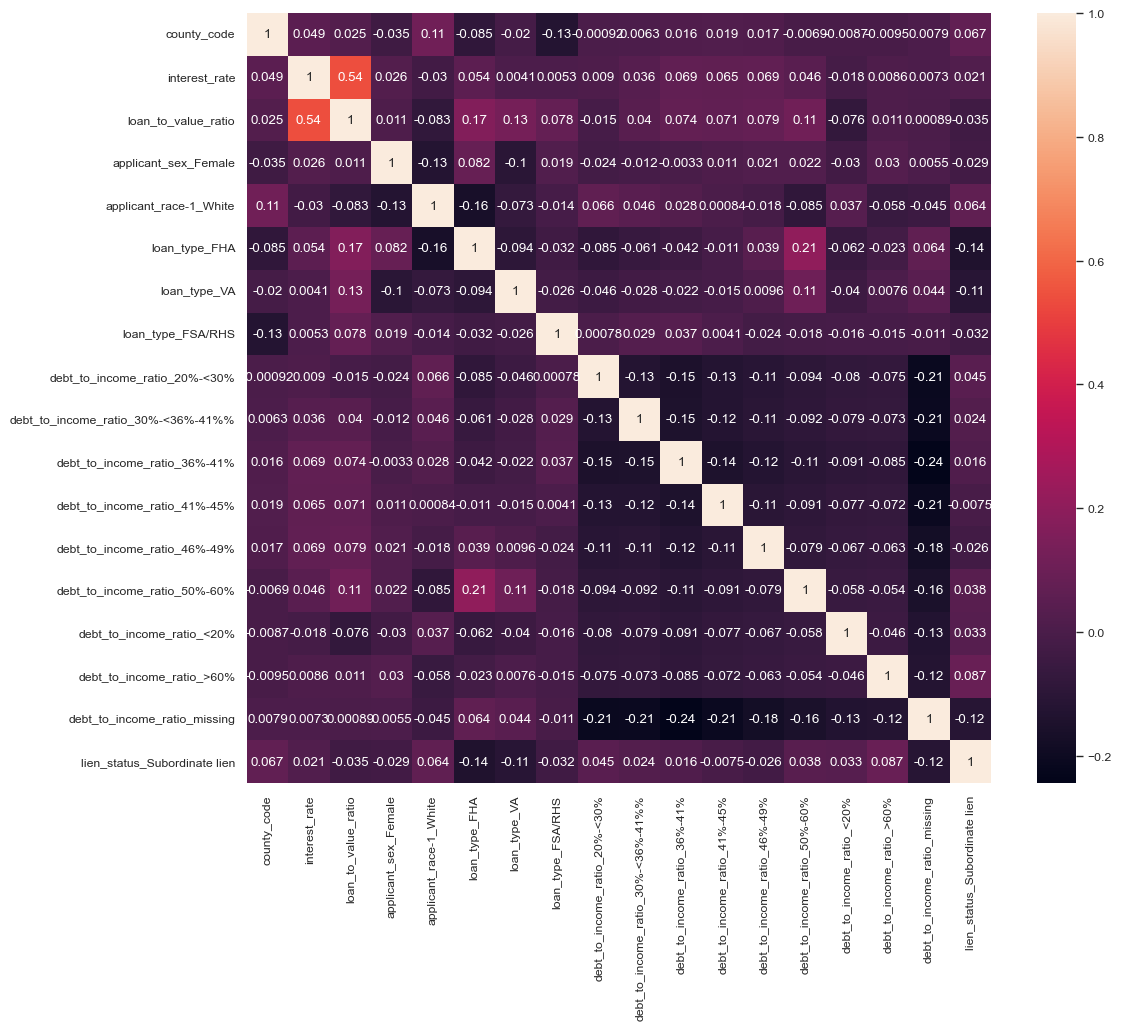

In [4]:
corr = X_train_scaled_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True)
plt.show()

In [5]:
from fairlearn.preprocessing import CorrelationRemover

cr = CorrelationRemover(sensitive_feature_ids=['applicant_race-1_White'])
cr.fit(X_train_scaled_df)
X_train_scaled_transform = cr.transform(X_train_scaled_df)

In [6]:
cr.fit(X_test_scaled_df)
X_test_scaled_transform = cr.transform(X_test_scaled_df)
X_test_scaled_transform = pd.DataFrame(X_test_scaled_transform, columns=X_column_names_trans)
X_test_scaled_transform["applicant_race-1_White"] = X_test_scaled_df["applicant_race-1_White"]

cr.fit(X_val_scaled_df)
X_val_scaled_transform = cr.transform(X_val_scaled_df)
X_val_scaled_transform = pd.DataFrame(X_val_scaled_transform, columns=X_column_names_trans)
X_val_scaled_transform["applicant_race-1_White"] = X_val_scaled_df["applicant_race-1_White"]

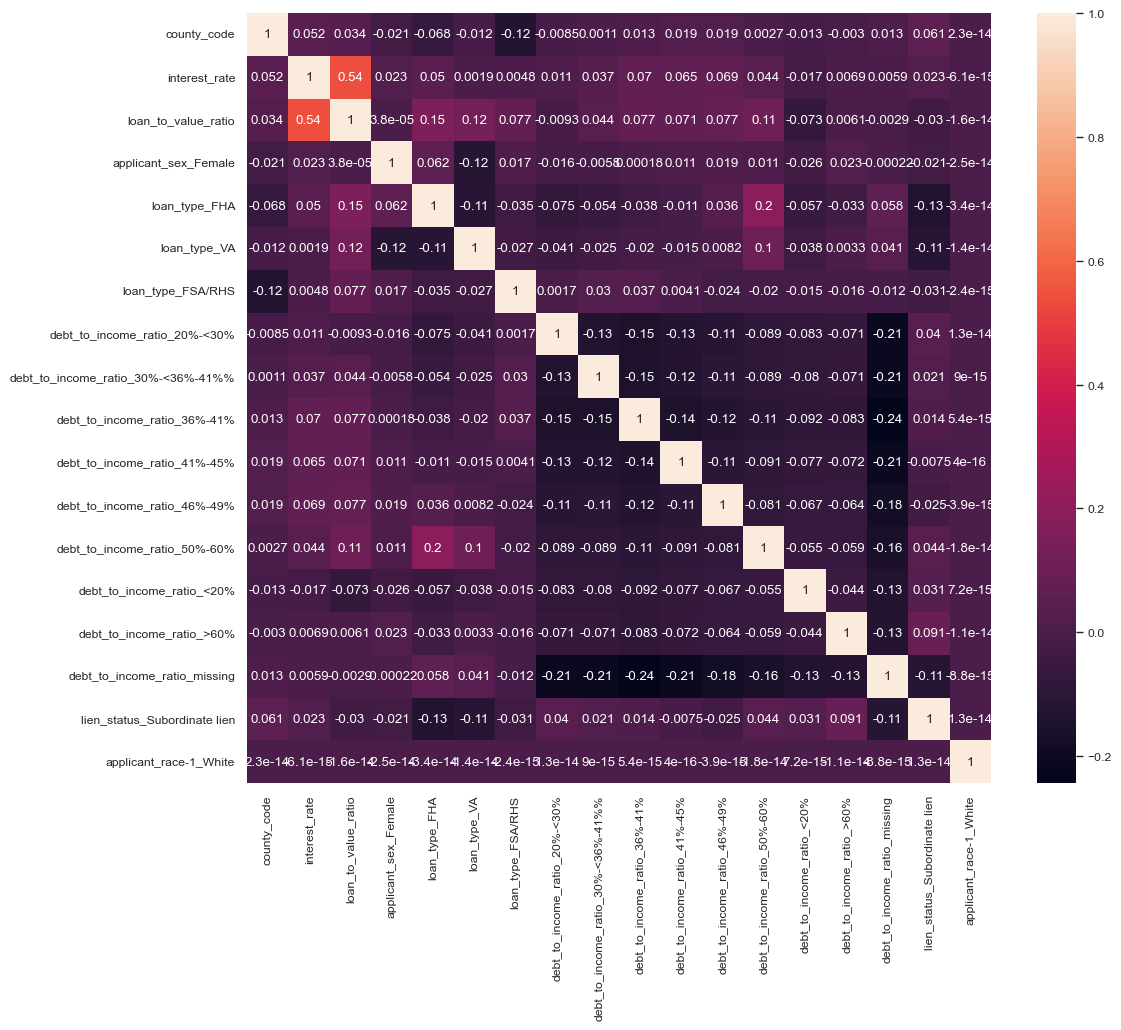

In [7]:
X_train_scaled_transform = pd.DataFrame(X_train_scaled_transform, columns=X_column_names_trans)
X_train_scaled_transform["applicant_race-1_White"] = X_train_scaled_df["applicant_race-1_White"]
corr_cr = X_train_scaled_transform.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_cr, annot=True)
plt.show()

In [8]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model = keras.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_scaled_transform, y_train, validation_data=(X_val_scaled_transform, y_val), epochs=30, batch_size=48, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
11360/11360 [==============================] - 34s 3ms/step - loss: 0.3438 - accuracy: 0.8759 - val_loss: 0.3024 - val_accuracy: 0.8936
Epoch 2/30
11360/11360 [==============================] - 27s 2ms/step - loss: 0.3014 - accuracy: 0.8940 - val_loss: 0.2956 - val_accuracy: 0.8982
Epoch 3/30
11360/11360 [==============================] - 27s 2ms/step - loss: 0.2973 - accuracy: 0.8955 - val_loss: 0.2931 - val_accuracy: 0.8967
Epoch 4/30
11360/11360 [==============================] - 24s 2ms/step - loss: 0.2942 - accuracy: 0.8967 - val_loss: 0.2920 - val_accuracy: 0.8990
Epoch 5/30
11360/11360 [==============================] - 23s 2ms/step - loss: 0.2927 - accuracy: 0.8973 - val_loss: 0.2873 - val_accuracy: 0.9003
Epoch 6/30
11360/11360 [==============================] - 25s 2ms/step - loss: 0.2919 - accuracy: 0.8979 - val_loss: 0.2845 - val_accuracy: 0.9012
Epoch 7/30
11360/11360 [==============================] - 29s 3ms/step - loss: 0.2912 - accuracy: 0.8983 - val_loss: 0

5325/5325 - 5s - loss: 0.2800 - accuracy: 0.9050 - 5s/epoch - 984us/step

Test accuracy: 0.9050285220146179


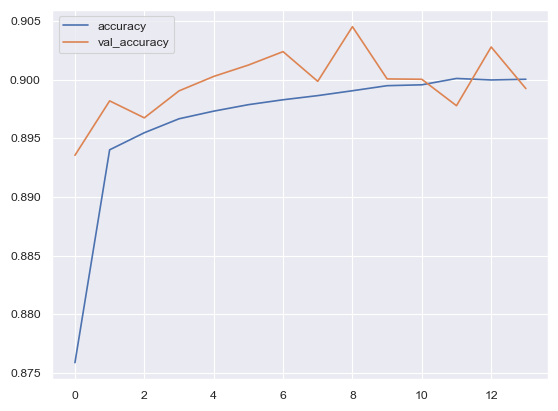

In [9]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

test_loss, test_acc = model.evaluate(X_test_scaled_transform, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

5325/5325 [==============================] - 5s 953us/step
[[58501 13147]
 [ 3035 95705]]
Accuracy: 0.905028523135432
Precision: 0.8792213280417448
Recall: 0.969262710147863
F1 Score: 0.922049019230028
AUC: 0.9429832813673364


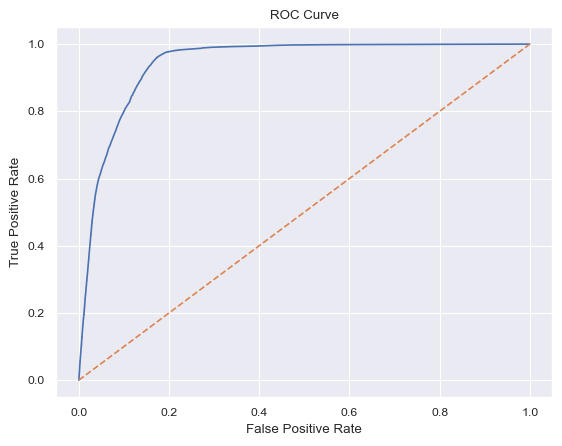

In [10]:
y_pred_proba = model.predict(X_test_scaled_transform)
y_pred = (y_pred_proba > 0.5)
y_pred_proba = y_pred_proba.ravel()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score(y_test, y_pred_proba))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

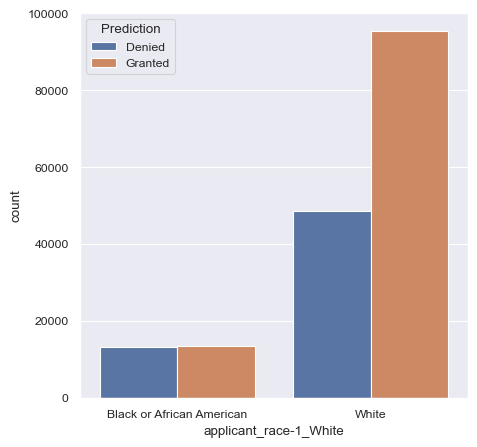

In [11]:
prediction_df = X_test_scaled_transform.copy()
prediction_df['prediction'] = y_pred
prediction_df['prediction_proba'] = y_pred_proba

plt.figure(figsize=(5, 5))
sns.countplot(data=prediction_df, x = "applicant_race-1_White", hue = "prediction")
plt.legend(title = "Prediction", labels = ["Denied", "Granted"])
plt.xticks(ticks=[0, 1], labels=["Black or African American", "White"])
plt.show()

In [12]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

privileged_groups = [{'applicant_race-1_White': 1}]
unprivileged_groups = [{'applicant_race-1_White': 0}]

pred_bld = BinaryLabelDataset(df=prediction_df, label_names=['prediction'], protected_attribute_names=['applicant_race-1_White'], favorable_label=1, unfavorable_label=0)

for col in prediction_df.columns:
    if prediction_df[col].dtype == "int":
        pred_bld.instance_weights = prediction_df[col]

metric_orig_pred = BinaryLabelDatasetMetric(pred_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_pred.mean_difference())

pip install 'aif360[inFairness]'


Difference in mean outcomes between unprivileged and privileged groups - Race = nan


c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\binary_label_dataset_metric.py:105: RuntimeWarning: invalid value encountered in double_scalars
  return (self.num_positives(privileged=privileged)


In [13]:
X_test_scaled_df.index = y_test.index

mask_white = X_test_scaled_df['applicant_race-1_White'] > 0
mask_black = X_test_scaled_df['applicant_race-1_White'] < 0

y_test_white_cor = y_test[mask_white]
y_test_black_cor = y_test[mask_black]

y_pred_corr_rem = prediction_df["prediction"]
y_pred_corr_rem = y_pred_corr_rem.astype(int)
y_pred_corr_rem.index = y_test.index

y_pred_white_cor = y_pred_corr_rem[mask_white]
y_pred_black_cor = y_pred_corr_rem[mask_black]

### AIF Adversarial Debiasing
https://github.com/Trusted-AI/AIF360/blob/main/examples/demo_adversarial_debiasing.ipynb

In [14]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

In [15]:
BLD_train_df = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/BLD_train_df.pkl")
BLD_val_df = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/BLD_val_df.pkl")
BLD_test_df = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/BLD_test_df.pkl")

privileged_groups = [{'applicant_race-1_White': 1}]
unprivileged_groups = [{'applicant_race-1_White': 0}]

train_bld = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White', 'applicant_race-1_Black or African American'], favorable_label=1.0, unfavorable_label=0.0)
val_bld = BinaryLabelDataset(df=BLD_val_df, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White', 'applicant_race-1_Black or African American'], favorable_label=1.0, unfavorable_label=0.0)
test_bld = BinaryLabelDataset(df=BLD_test_df, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White', 'applicant_race-1_Black or African American'], favorable_label=1.0, unfavorable_label=0.0)

metric_orig_train = BinaryLabelDatasetMetric(train_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Original Training Data")
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_val = BinaryLabelDatasetMetric(val_bld,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Original Validation Data")
print("Val set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_val.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(test_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Original Test Data")
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

Original Training Data
Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.148808
Original Validation Data
Val set: Difference in mean outcomes between unprivileged and privileged groups = -0.149007
Original Test Data
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.149177


In [16]:
'''import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)'''

"import tensorflow.compat.v1 as tf\ntf.disable_eager_execution()\n\nsess = tf.Session()\nplain_model = AdversarialDebiasing(privileged_groups = privileged_groups,\n                          unprivileged_groups = unprivileged_groups,\n                          scope_name='plain_classifier',\n                          debias=False,\n                          sess=sess)"

In [17]:
# plain_model.fit(train_bld)

In [18]:
# dataset_nodebiasing_train = plain_model.predict(train_bld)
# dataset_nodebiasing_test = plain_model.predict(test_bld)

In [19]:
'''print("Plain model - without debiasing - dataset metrics")
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

print("Plain model - without debiasing - classification metrics")
classified_metric_nodebiasing_test = ClassificationMetric(test_bld, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())'''

'print("Plain model - without debiasing - dataset metrics")\nmetric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, \n                                             unprivileged_groups=unprivileged_groups,\n                                             privileged_groups=privileged_groups)\n\nprint("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())\n\nmetric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, \n                                             unprivileged_groups=unprivileged_groups,\n                                             privileged_groups=privileged_groups)\n\nprint("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())\n\nprint("Plain model - without debiasing - classification metrics")\nclassified_metric_nodebiasing_test = Classificatio

In [20]:
'''sess.close()
tf.reset_default_graph()
sess = tf.Session()'''

'sess.close()\ntf.reset_default_graph()\nsess = tf.Session()'

In [21]:
'''debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)'''

"debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,\n                          unprivileged_groups = unprivileged_groups,\n                          scope_name='debiased_classifier',\n                          debias=True,\n                          sess=sess)"

In [22]:
# debiased_model.fit(train_bld)

In [23]:
# dataset_debiasing_train = debiased_model.predict(train_bld)
# dataset_debiasing_test = debiased_model.predict(test_bld)

In [24]:
'''print("#### Plain model - without debiasing - dataset metrics")
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

print("#### Model - with debiasing - dataset metrics")
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



print("#### Plain model - without debiasing - classification metrics")
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())



print("#### Model - with debiasing - classification metrics")
classified_metric_debiasing_test = ClassificationMetric(test_bld, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())'''

'print("#### Plain model - without debiasing - dataset metrics")\nprint("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())\nprint("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())\n\nprint("#### Model - with debiasing - dataset metrics")\nmetric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, \n                                             unprivileged_groups=unprivileged_groups,\n                                             privileged_groups=privileged_groups)\n\nprint("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())\n\nmetric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, \n                                             unprivileged_groups=unprivileged_groups,\n 

### Calibrated eqodds postprocessing
https://github.com/Trusted-AI/AIF360/blob/main/examples/demo_calibrated_eqodds_postprocessing.ipynb

In [25]:
metric_orig_train = BinaryLabelDatasetMetric(train_bld, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("#### Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_valid = BinaryLabelDatasetMetric(val_bld, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("#### Original validation dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_valid.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(test_bld, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("#### Original test dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.148808
#### Original validation dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.149007
#### Original test dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.149177


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = train_bld.copy(deepcopy=True)
dataset_orig_valid_pred = val_bld.copy(deepcopy=True)
dataset_orig_test_pred = test_bld.copy(deepcopy=True)

dataset_new_valid_pred = val_bld.copy(deepcopy=True)
dataset_new_test_pred = test_bld.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(train_bld.features)
y_train = train_bld.labels.ravel()
lmod = LogisticRegression()
lmod.fit(X_train, y_train)

fav_idx = np.where(lmod.classes_ == train_bld.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = scale_orig.transform(val_bld.features)
y_valid_pred_prob = lmod.predict_proba(X_valid)[:,fav_idx]

X_test = scale_orig.transform(test_bld.features)
y_test_pred_prob = lmod.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred
    
y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

In [27]:
cm_pred_train = ClassificationMetric(train_bld, dataset_orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("#### Original-Predicted training dataset")
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(val_bld, dataset_orig_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("#### Original-Predicted validation dataset")
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

cm_pred_test = ClassificationMetric(test_bld, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("#### Original-Predicted testing dataset")
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

#### Original-Predicted training dataset
Difference in GFPR between unprivileged and privileged groups
-0.04739783131559244
Difference in GFNR between unprivileged and privileged groups
0.10818738833892311
#### Original-Predicted validation dataset
Difference in GFPR between unprivileged and privileged groups
-0.03989396586732874
Difference in GFNR between unprivileged and privileged groups
0.10813945850438036
#### Original-Predicted testing dataset
Difference in GFPR between unprivileged and privileged groups
-0.048608891661645504
Difference in GFNR between unprivileged and privileged groups
0.10805188988329487


In [28]:
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm

cost_constraint = "fnr" # "fnr", "fpr", "weighted"

cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=69)

cpp = cpp.fit(val_bld, dataset_orig_valid_pred)

In [29]:
dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

In [30]:
cm_transf_valid = ClassificationMetric(val_bld, dataset_transf_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("#### Original-Transformed validation dataset")
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))

cm_transf_test = ClassificationMetric(test_bld, dataset_transf_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("#### Original-Transformed testing dataset")
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))

#### Original-Transformed validation dataset
Difference in GFPR between unprivileged and privileged groups
-0.20368017550697892
Difference in GFNR between unprivileged and privileged groups
0.0007375853636603091
#### Original-Transformed testing dataset
Difference in GFPR between unprivileged and privileged groups
-0.2108750527196841
Difference in GFNR between unprivileged and privileged groups
-0.0001376077894369998


In [31]:
assert np.abs(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate)) < np.abs(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate)) 

In [32]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
print("#### Classification thresholds used for validation and parameter selection")

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh = dataset_orig_valid_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    
    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(val_bld,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(test_bld,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
                                     val_bld, 
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(test_bld,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))

#### Classification thresholds used for validation and parameter selection


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


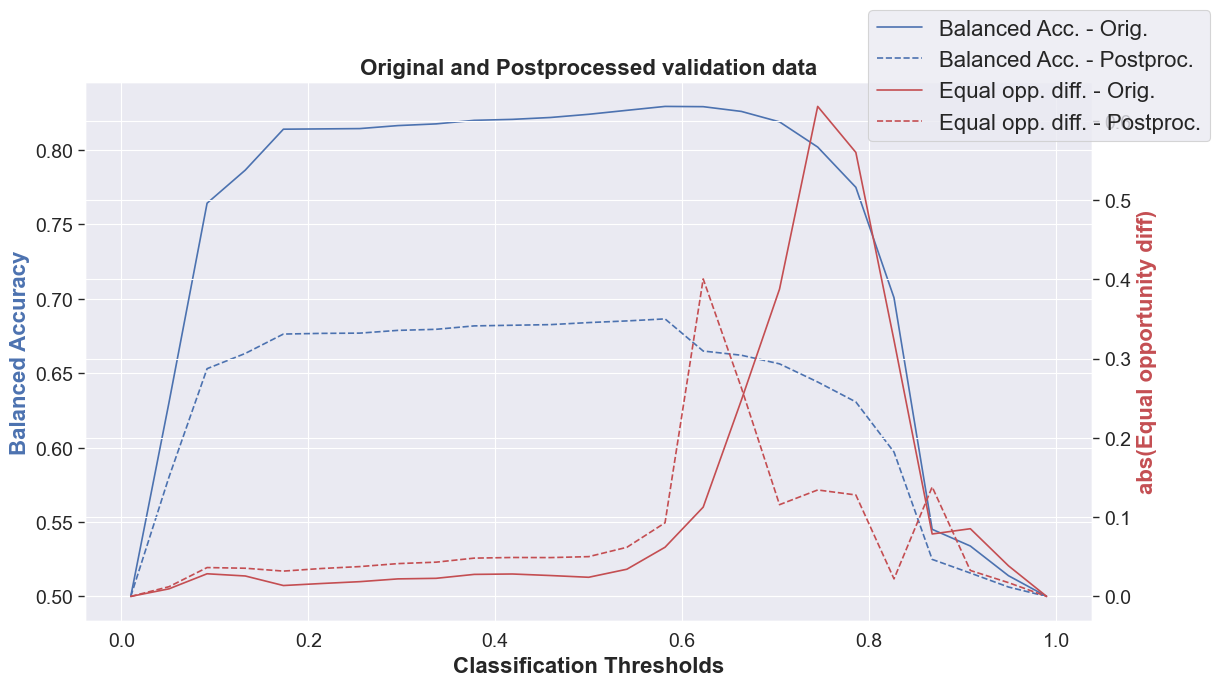

In [33]:
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",], 
           fontsize=16)

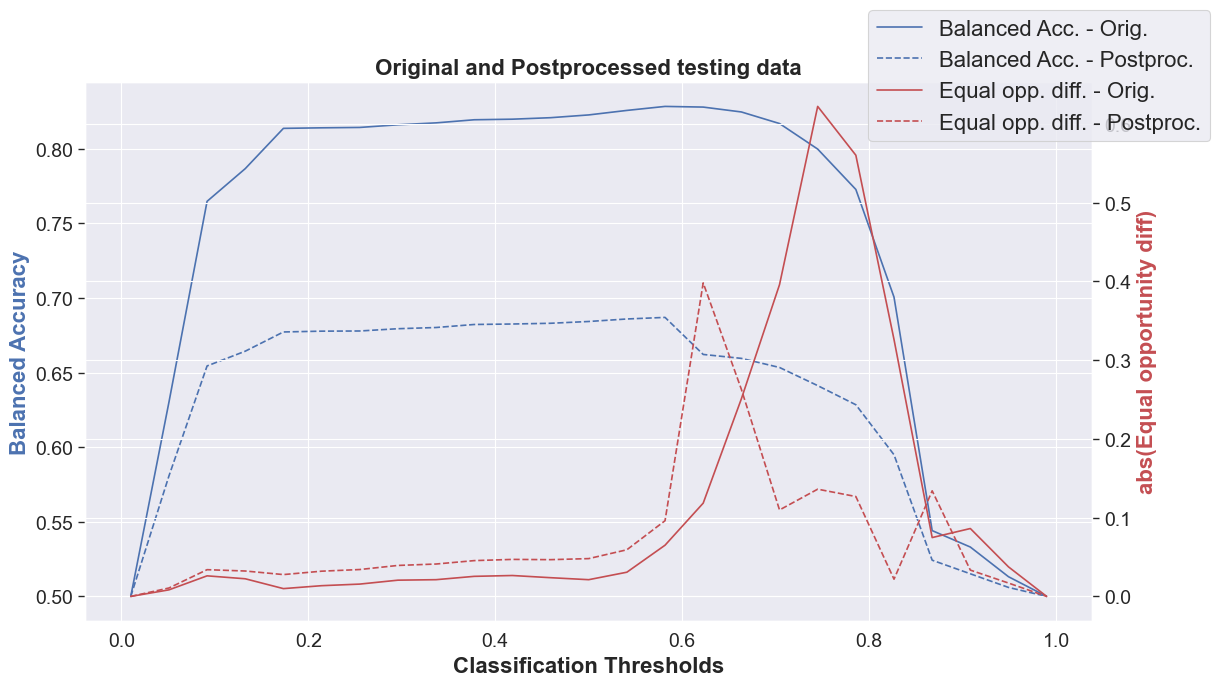

In [34]:
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
            "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
           fontsize=16)

In [35]:
dataset_transf_test_pred.convert_to_dataframe()[0]["loan_granted"].describe()

count    170388.000000
mean          0.817904
std           0.385925
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: loan_granted, dtype: float64

In [36]:
dataset_orig_test_pred.convert_to_dataframe()[0]["loan_granted"].describe()

count    170388.000000
mean          0.677988
std           0.467249
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: loan_granted, dtype: float64

In [37]:
eqodds_predictions = dataset_transf_test_pred.convert_to_dataframe()[0]

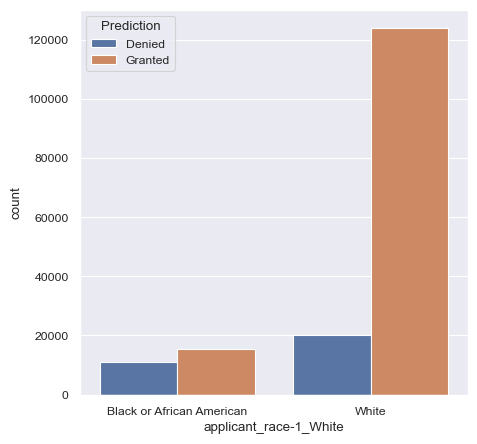

In [38]:
plt.figure(figsize=(5, 5))
sns.countplot(data=eqodds_predictions, x = "applicant_race-1_White", hue = "loan_granted")
plt.legend(title = "Prediction", labels = ["Denied", "Granted"])
plt.xticks(ticks=[0, 1], labels=["Black or African American", "White"])
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, eqodds_predictions["loan_granted"])
print(cm)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_test, eqodds_predictions["loan_granted"]))
print("Precision:", precision_score(y_test, eqodds_predictions["loan_granted"]))
print("Recall:", recall_score(y_test, eqodds_predictions["loan_granted"]))
print("F1 Score:", f1_score(y_test, eqodds_predictions["loan_granted"]))

[[28344 43304]
 [ 2683 96057]]
Accuracy: 0.7301042326924432
Precision: 0.6892674421107771
Recall: 0.9728276281142394
F1 Score: 0.8068592740055692


In [40]:
pred_bld = BinaryLabelDataset(df=eqodds_predictions, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White'], favorable_label=1.0, unfavorable_label=0.0)

metric_orig_pred = BinaryLabelDatasetMetric(pred_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_pred.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.279199


In [41]:
with open(pickle_file_path, 'rb') as f:
    subsets = pickle.load(f)

X_train_scaled = subsets['X_train_scaled']
X_test_scaled = subsets['X_test_scaled']
X_val_scaled = subsets['X_val_scaled']
y_train = subsets['y_train']
y_test = subsets['y_test']
y_val = subsets['y_val']

In [42]:
X_test_scaled_df.index = y_test.index

mask_white = X_test_scaled_df['applicant_race-1_White'] > 0
mask_black = X_test_scaled_df['applicant_race-1_White'] < 0

y_test_white = y_test[mask_white]
y_test_black = y_test[mask_black]

y_pred_eqodds = eqodds_predictions["loan_granted"]
y_pred_eqodds = y_pred_eqodds.astype(int)
y_pred_eqodds.index = y_test.index

y_pred_white = y_pred_eqodds[mask_white]
y_pred_black = y_pred_eqodds[mask_black]

comp_df_cal_eqodds_corr = pd.DataFrame({"Equalized Odds": [accuracy_score(y_test_white, y_pred_white), precision_score(y_test_white, y_pred_white), recall_score(y_test_white, y_pred_white), f1_score(y_test_white, y_pred_white), "NA",
                                     accuracy_score(y_test_black, y_pred_black), precision_score(y_test_black, y_pred_black), recall_score(y_test_black, y_pred_black), f1_score(y_test_black, y_pred_black), "NA"],
                                     "Correlation Removal": [accuracy_score(y_test_white_cor, y_pred_white_cor), precision_score(y_test_white_cor, y_pred_white_cor), recall_score(y_test_white_cor, y_pred_white_cor), f1_score(y_test_white_cor, y_pred_white_cor), "NA",
                                                             accuracy_score(y_test_black_cor, y_pred_black_cor), precision_score(y_test_black_cor, y_pred_black_cor), recall_score(y_test_black_cor, y_pred_black_cor), f1_score(y_test_black_cor, y_pred_black_cor), "NA"]})

comp_df_cal_eqodds_corr.index = ["Accuracy White", "Precision White", "Recall White", "F1 Score White", "AUC White", "Accuracy Black", "Precision Black", "Recall Black", "F1 Score Black", "AUC Black"]

comp_df_cal_eqodds_corr

,Equalized Odds,Correlation Removal
Accuracy White,0.715691,0.908591
Precision White,0.68482,0.885405
Recall White,0.978661,0.974442
F1 Score White,0.805788,0.927793
AUC White,NA,NA
Accuracy Black,0.808528,0.885646
Precision Black,0.725076,0.835114
Recall Black,0.930644,0.931811
F1 Score Black,0.815099,0.880816
AUC Black,NA,NA


In [43]:
comp_df_cal_eqodds_corr.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/result_frames/performance/comp_df_cal_eqodds.pkl")

In [44]:
HMDA_clean_final = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/HMDA_clean_final.pkl")

results = pd.DataFrame({'label': y_test})
results["score"] = y_pred_eqodds.astype(int)
results["applicant_race-1"] = HMDA_clean_final.loc[results.index, "applicant_race-1"]

results_rew = pd.DataFrame({'label': y_test})
results_rew["score"] = y_pred_corr_rem.astype(int)
results_rew["applicant_race-1"] = HMDA_clean_final.loc[results_rew.index, "applicant_race-1"]

results["label"] = results["label"].astype("int")
results["score"] = results["score"].astype("int")

results_rew["label"] = results_rew["label"].astype("int")
results_rew["score"] = results_rew["score"].astype("int")

results["applicant_race-1"] = results["applicant_race-1"].astype("object")
results_rew["applicant_race-1"] = results_rew["applicant_race-1"].astype("object")

In [45]:
import aequitas

audit_cal_eqodds = aequitas.Audit(results)
audit_corr_rem = aequitas.Audit(results_rew)

In [46]:
g = aequitas.group.Group()

results_ren = results.copy()
results_ren["label_value"] = results["label"]
results_ren.drop(columns="label", inplace=True)

results_ren_rew = results_rew.copy()
results_ren_rew["label_value"] = results_rew["label"]
results_ren_rew.drop(columns="label", inplace=True)

xtab, _ = g.get_crosstabs(results_ren)
xtab_rew, _ = g.get_crosstabs(results_ren_rew)

In [47]:
absolute_metrics_eqodds = g.list_absolute_metrics(xtab)
absolute_metrics_corr_rem = g.list_absolute_metrics(xtab_rew)

In [48]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics_eqodds].round(2)

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,applicant_race-1,Black or African American,0.81,0.93,0.71,0.08,0.27,0.29,0.07,0.92,0.73,0.11,0.58,0.45
1,applicant_race-1,White,0.72,0.98,0.32,0.09,0.32,0.68,0.02,0.91,0.68,0.89,0.86,0.60


In [49]:
xtab_rew[['attribute_name', 'attribute_value'] + absolute_metrics_corr_rem].round(2)

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,applicant_race-1,Black or African American,0.89,0.93,0.85,0.06,0.16,0.15,0.07,0.94,0.84,0.12,0.51,0.45
1,applicant_race-1,White,0.91,0.97,0.81,0.05,0.11,0.19,0.03,0.95,0.89,0.88,0.66,0.60


In [50]:
aqp = aequitas.plotting.Plot()

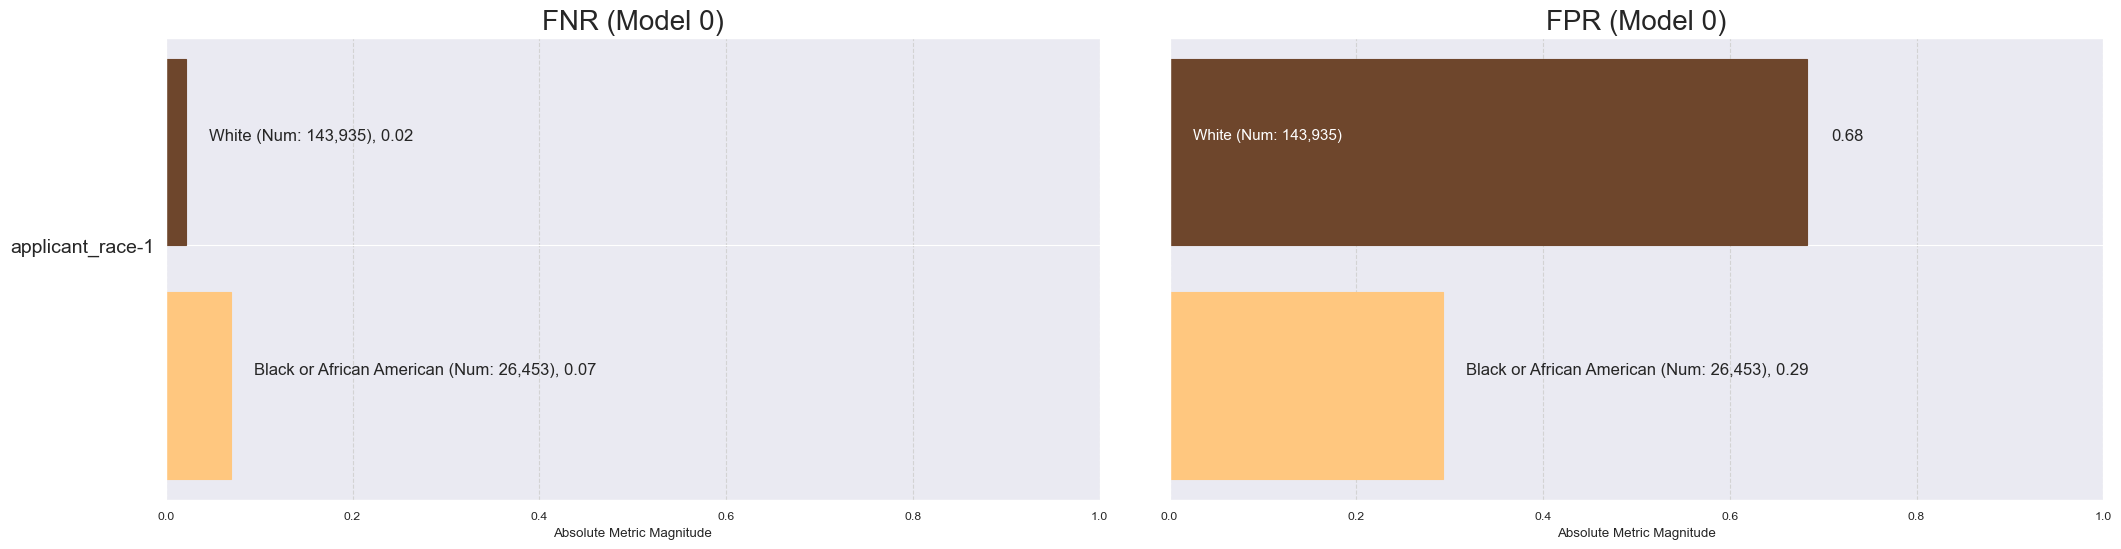

<Figure size 640x480 with 0 Axes>

In [51]:
group_metric_all = aqp.plot_group_metric_all(xtab, metrics=['fnr','fpr'], ncols=2)

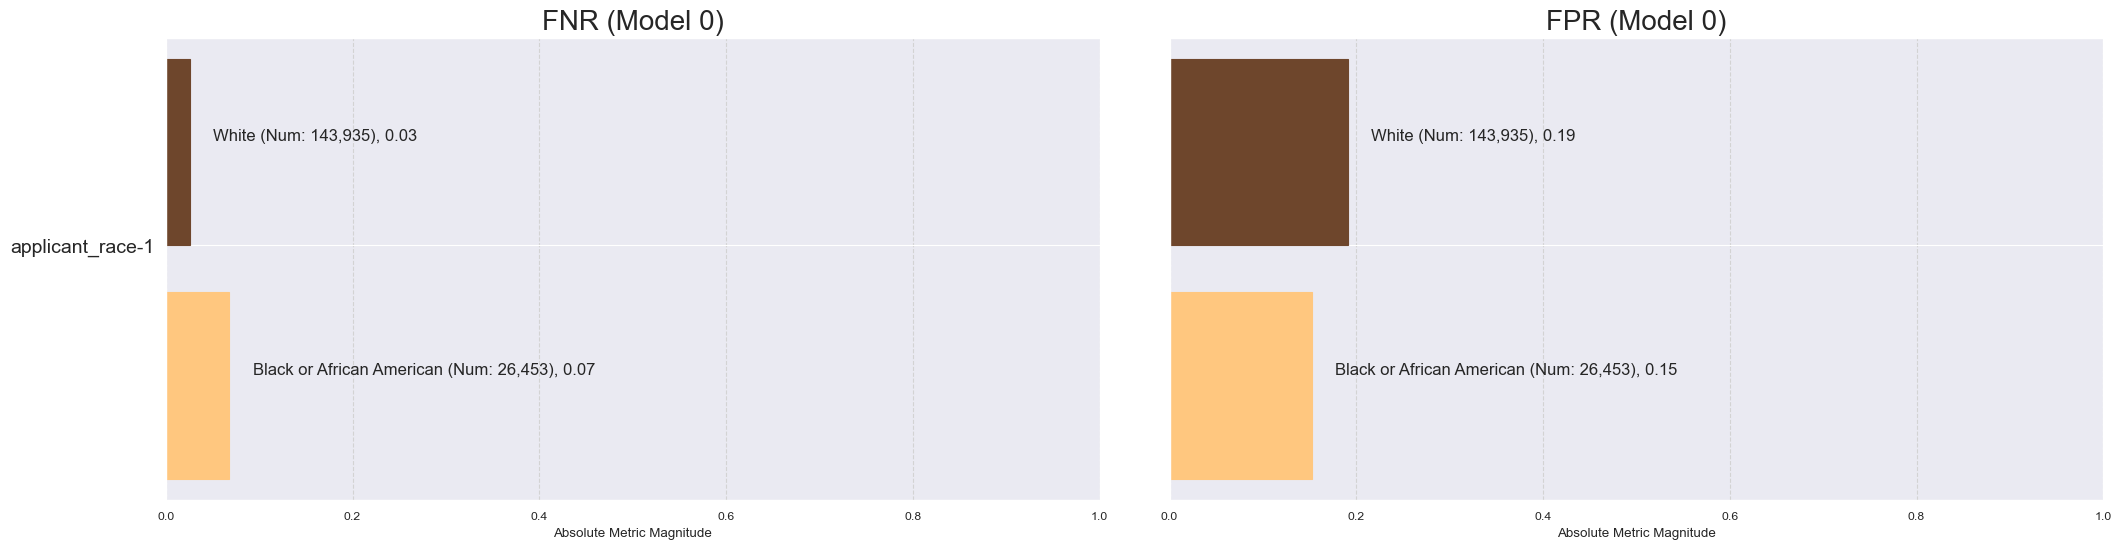

<Figure size 640x480 with 0 Axes>

In [52]:
group_metric_all_cor = aqp.plot_group_metric_all(xtab_rew, metrics=['fnr','fpr'], ncols=2)

In [53]:
b = aequitas.bias.Bias()

In [54]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=results_ren, ref_groups_dict={'applicant_race-1':'White'}, alpha=0.05, mask_significance=True)
bdf.style

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,139361,applicant_race-1,Black or African American,0.808528,0.930644,0.707201,0.075253,0.274924,0.292799,0.069356,0.924747,0.725076,15397,11056,0.110483,0.582051,4233,832,10224,11164,11996,14457,26453,170388,0.453484,0.124205,0.675822,1.058784,0.872275,0.811930,0.428591,3.250273,0.950935,2.232092,1.019212,White,White,White,White,White,White,White,White,White,White
1,0,binary 0/1,139361,applicant_race-1,White,0.715691,0.978661,0.316833,0.092684,0.315180,0.683167,0.021339,0.907316,0.684820,123964,19971,0.889517,0.861250,39071,1851,18120,84893,86744,57191,143935,170388,0.602661,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,White,White,White,White,White,White,White,White,White,White


In [55]:
bdf_cor = b.get_disparity_predefined_groups(xtab_rew, original_df=results_ren_rew, ref_groups_dict={'applicant_race-1':'White'}, alpha=0.05, mask_significance=True)
bdf_cor.style

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,108852,applicant_race-1,Black or African American,0.885646,0.931811,0.847340,0.062596,0.164886,0.152660,0.068189,0.937404,0.835114,13385,13068,0.122965,0.505992,2207,818,12250,11178,11996,14457,26453,170388,0.453484,0.140206,0.762881,0.943199,1.438865,1.368465,0.798058,2.668029,0.956250,1.047766,0.982338,White,White,White,White,White,White,White,White,White,White
1,0,binary 0/1,108852,applicant_race-1,White,0.908591,0.974442,0.808711,0.045742,0.114595,0.191289,0.025558,0.954258,0.885405,95467,48468,0.877035,0.663265,10940,2217,46251,84527,86744,57191,143935,170388,0.602661,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,White,White,White,White,White,White,White,White,White,White


In [56]:
eqodds_results_total = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, eqodds_predictions["loan_granted"])],
    'precision': [precision_score(y_test, eqodds_predictions["loan_granted"])],
    'recall': [recall_score(y_test, eqodds_predictions["loan_granted"])],
    'f1': [f1_score(y_test, eqodds_predictions["loan_granted"])],
    'roc_auc': "NA",
    'tpr_disparity': [bdf['tpr_disparity'][0]],
    'fpr_disparity': [bdf['fpr_disparity'][0]],
    'tnr_disparity': [bdf['tnr_disparity'][0]],
    'fnr_disparity': [bdf['fnr_disparity'][0]]
})

corr_rem_results_total = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1': [f1_score(y_test, y_pred)],
    'roc_auc': "NA",
    'tpr_disparity': [bdf_cor['tpr_disparity'][0]],
    'fpr_disparity': [bdf_cor['fpr_disparity'][0]],
    'tnr_disparity': [bdf_cor['tnr_disparity'][0]],
    'fnr_disparity': [bdf_cor['fnr_disparity'][0]]
})

results_df = pd.concat([eqodds_results_total, corr_rem_results_total], axis=0)
results_df.index = ['Cal. Eq. Odds', 'Corr. Rem.']
results_df = results_df.T
results_df

,Cal. Eq. Odds,Corr. Rem.
accuracy,0.730104,0.905029
precision,0.689267,0.879221
recall,0.972828,0.969263
f1,0.806859,0.922049
roc_auc,NA,NA
tpr_disparity,0.950935,0.95625
fpr_disparity,0.428591,0.798058
tnr_disparity,2.232092,1.047766
fnr_disparity,3.250273,2.668029


In [57]:
results_df.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/result_frames/performance/results_df_eqodds_cor.pkl")